In [1]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /root/.julia/packages/Revise/lwch5/src/Revise.jl:866


# The problem

We're computing a pure dirichlet problem with gravity in a rectangular box. In other words, there's a downward body force and all four sides of the box have zero displacement. 

# FEM Solution

First, I run some Python code to run a fenics calculation for a rectangular box that is 50% large than our domain of interest. Important features here:
* zero dirichlet boundary conditions on all boundaries
* larger domain: `RectangleMesh(Point((-1.5 * width, -3 * width)), Point((1.5 * width, width)), 200, 200)`
* the body force is included: `f = Constant((0, -rho*g))`

In [2]:
py"""
from fenics import *
from ufl import nabla_div
from dataclasses import dataclass
import matplotlib.pyplot as plt

# Variables
mu = 3e10
rho = 2700
width = 10e3
lambda_ = mu
g = 9.81
# Calculate strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

# Calculate stress
def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Boundary conditions
def clamped_boundary(x, on_boundary):
    return on_boundary

# Create mesh and define function space
mesh = RectangleMesh(Point((-1.5 * width, -3 * width)), Point((1.5 * width, width)), 200, 200)
"""

In [3]:
py"""
V = VectorFunctionSpace(mesh, 'P', 1)
bc = DirichletBC(V, Constant((0, 0)), clamped_boundary)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, -rho*g))
T = Constant((0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Evaluate the solution at a an arbitrary new point
u_eval = u(0, -width)
print(u_eval)
"""

Solving linear variational problem.


In [4]:
py"""
ux = dot(u,Constant((1.0, 0.0)))
uy = dot(u,Constant((0.0, 1.0)))
umag = sqrt(ux ** 2 + uy ** 2)
"""

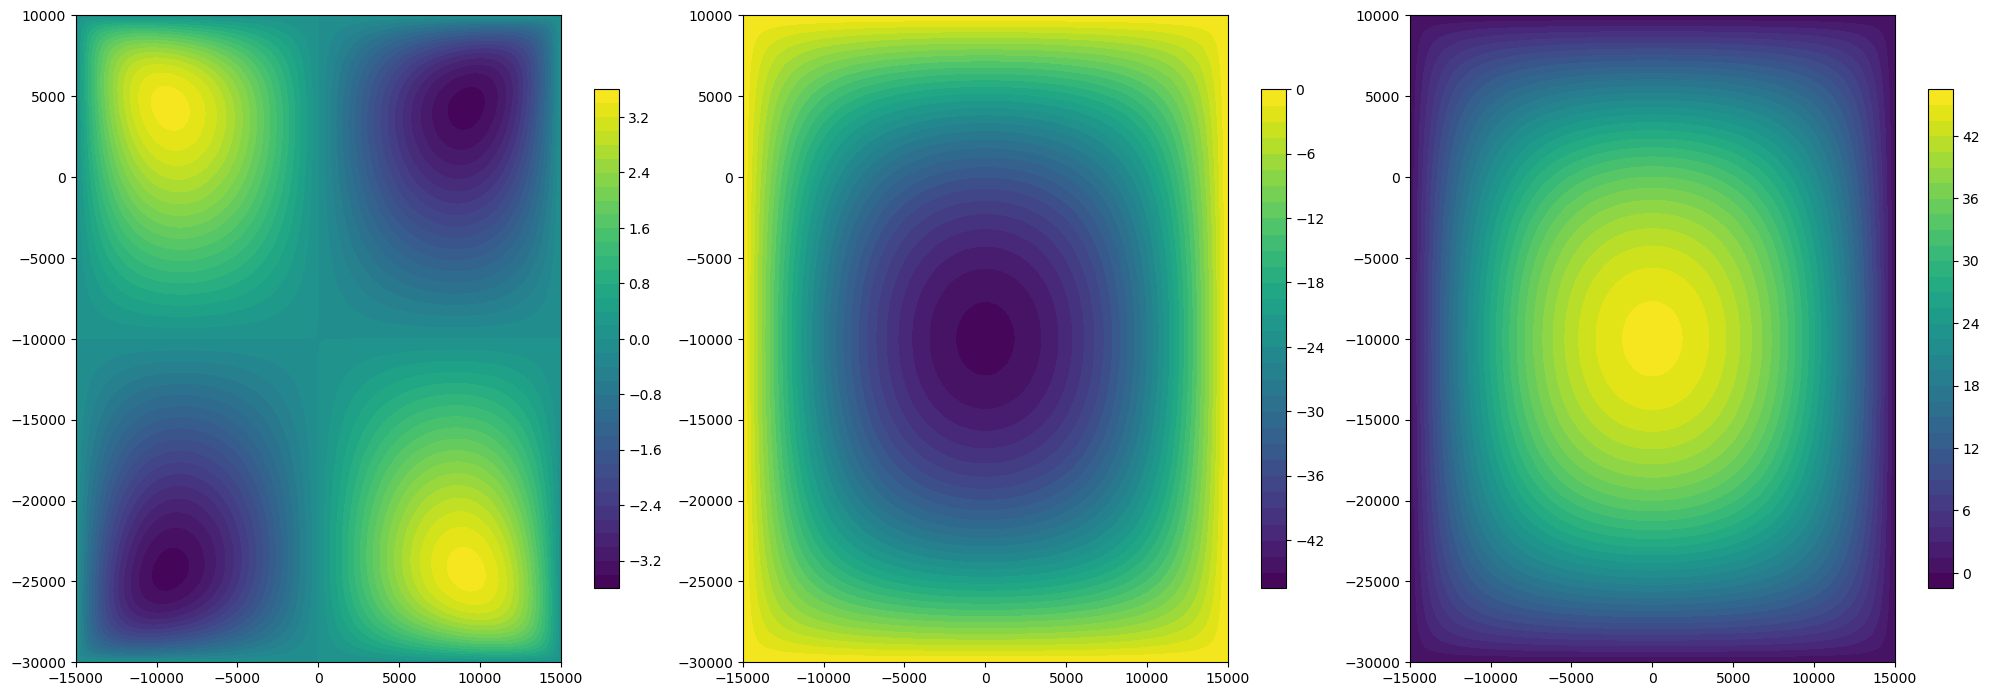

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [5]:
py"""
plt.figure(figsize=(20, 15))

plt.subplot(1,3,1)
c = plot(ux, colobar=True)
plt.colorbar(c,fraction=0.046, pad=0.06)

plt.subplot(1,3,2)
c = plot(uy, colobar=True)
plt.colorbar(c,fraction=0.046, pad=0.06)

plt.subplot(1,3,3)
c = plot(umag, colobar=True)
plt.colorbar(c,fraction=0.046, pad=0.06)
plt.tight_layout()
"""

In [13]:
py"""
sxx_sxy = project(dot(sigma(u), Constant((1,0))), V)
sxy_syy = project(dot(sigma(u), Constant((0,1))), V)
"""

In [15]:
py"sxx_sxy(0, 0)"

2-element Array{Float64,1}:
    2.435300374635953e7
 -803.5217616941752    

# BEM Solution

Now, we're going to solve a Julia Bem2d.jl problem on the true domain. Important features here:
* the dirichlet (displacement) boundary conditions are equal to the negative displacement from the FEM problem evaluated at the centers of the boundary elements.
* The interior evaluation displacement is equal to the sum of the BEM solution and the FEM solution. 
* There is no gravity body force here. The entire effect of the gravity body force is being passed through the boundary conditions from the FEM problem.

In [17]:
mu = py"mu"
lambda = py"lambda_"
nu = lambda / (2 * (lambda + mu))
rho = py"rho"
g = py"g"
nels = 50
L = py"width"

10000.0

In [18]:
# Boundary mesh
els = Elements(Int(1e5))
addelsez!(els, discretizedline(-L, -2*L, L, -2*L, nels)..., "B") # Bottom
addelsez!(els, discretizedline(L, -2*L, L, 0, nels)... , "R") # Right hand side
addelsez!(els, discretizedline(L, 0, -L, 0, nels)..., "T") # Top
addelsez!(els, discretizedline(-L, 0, -L, -2*L, nels)..., "L") # Left hand side

In [28]:
# Build BEM operator, TH
idx = getidxdict(els)
T_pU_qall, _ = PUTC(slip2dispstress, els, idx["B"], 1:1:els.endidx, mu, nu)
_, H_pT_qall = PUTC(slip2dispstress, els, [idx["R"] ; idx["T"]; idx["L"]], 1:1:els.endidx, mu, nu)
TH = [T_pU_qall ; H_pT_qall];

function fem_eval_u(idx, x, y)
    n = length(idx)
    fem_eval = zeros(2*n)
    for idx_i in 1:n
        i = idx[idx_i]
        fem_eval[(2*idx_i - 1):(2*idx_i)] = py"u"(x[i], y[i])
    end
    return fem_eval
end
function fem_eval_t(idx, x, y, xn, yn)
    n = length(idx)
    fem_eval = zeros(2*n)
    for idx_i in 1:n
        i = idx[idx_i]
        sxx, sxy = py"sxx_sxy"(x[i], y[i])
        sxy2, syy = py"sxy_syy"(x[i], y[i])
        tx = sxx * xn[i] + sxy * yn[i]
        ty = sxy * xn[i] + syy * yn[i]
        fem_eval[2*idx_i - 1] = tx
        fem_eval[2*idx_i] = ty
    end
    return fem_eval
end
bcs_B = -fem_eval_u(idx["B"], els.xcenter, els.ycenter)
bcs_RTL = -fem_eval_t([idx["R"] ; idx["T"]; idx["L"]], els.xcenter, els.ycenter, els.xnormal, els.ynormal);

getidx found 50 elements with label "B"
getidx found 50 elements with label "R"
getidx found 50 elements with label "T"
getidx found 50 elements with label "L"


In [35]:
bcs = zeros(2 * els.endidx)
bcs[1:2*nels] = bcs_B
bcs[2*nels+1:end] = bcs_RTL;

In [37]:
Ueff = TH \ bcs;

In [42]:
function interior_eval(x, y)
    n = length(x)
    out = constdispstress(slip2dispstress, x, y, els, 1:1:els.endidx, Ueff[1:2:end], Ueff[2:2:end], mu, nu)[1]
    fem_xy = zeros(2*n)
    for i in 1:n
        fem_xy[(2*i - 1):(2*i)] = py"u"(x[i], y[i])
    end
    out[:, 1] += fem_xy[1:2:end]
    out[:, 2] += fem_xy[2:2:end]
    return out
end

interior_eval (generic function with 1 method)

In [43]:
# Forward solution on grid
npts = 50
offset = 100
x, y = obsgrid(-L+offset, -2*L+offset, L-offset, -offset, npts)
Utotal = interior_eval(x,y)
Umag = sqrt.(Utotal[:, 1].^2 + Utotal[:, 2].^2);

# Results

Magic! It works! The plots below are identical to the ones produced directly in `baseline_dirichlet.ipynb` and `py_baseline_dirichlet.ipynb`.

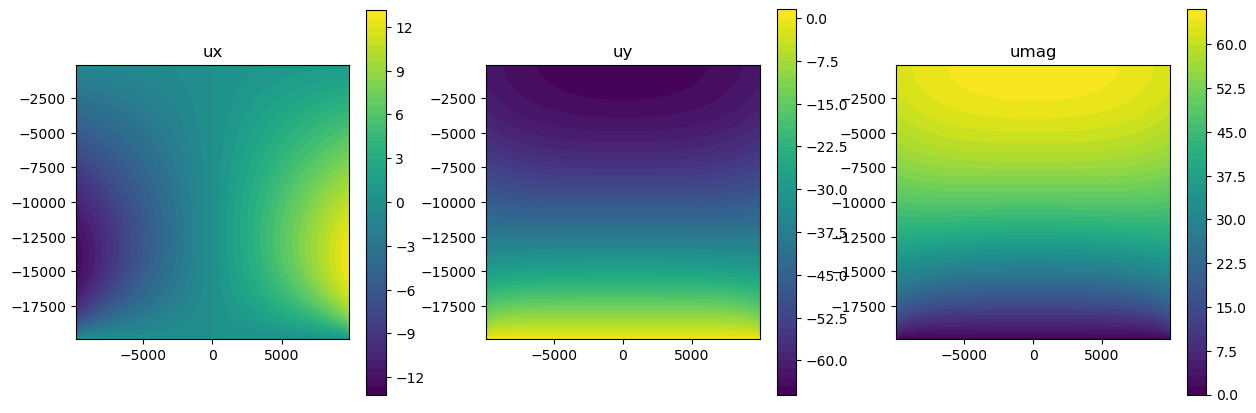

In [44]:
figure(figsize=(15, 5))
subplot(1, 3, 1)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 1], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("ux")
subplot(1, 3, 2)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 2], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("uy")
subplot(1, 3, 3)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Umag, npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("umag");